<ul>
  <li>Ilyes Tebourski</li>
    <li>Ahmad Hussein</li>
  <li>Sébastien Bonna</li>

</ul>

Environnement utilisé : Python 3.11.9


<h2 style="text-align: center;">Projet UE Optimisation : Réimplémentation du papier scientifique</h1>


### Introduction

Le but de ce notebook est de réimplémenter une approche inspirée de l'Article 4 :  
**"Forecasting Hospital Bed Capacity Using Machine Learning and Deep Learning Techniques"**  

L'article propose une méthodologie "data-driven" combinant des modèles de Machine Learning et Deep Learning pour prédire les besoins en lits hospitaliers à partir des **durées de séjour (LOS)** et du **nombre de patients hospitalisés (NHP)**. Contrairement aux approches classiques fondées sur des modèles de simulation rigides, cette étude exploite les prédictions LOS (via des classificateurs comme KNN, SVM, Decision Tree, etc.) et les prévisions de NHP (via SARIMA, LSTM, etc.) pour alimenter un modèle mathématique simple de planification de capacité. 

Comme nous n'avons pas pu accéder au dataset original de l’article, nous avons utilisé un autre jeu de données réel, provenant de l'institut **Hero DMC Heart Institute**, en Inde.  
 **Période couverte** : 1er avril 2017 au 31 mars 2019  
 **Lieu** : Dayanand Medical College and Hospital, Ludhiana, Punjab  
 **Volume** : 14 845 admissions correspondant à 12 238 patients

Ce jeu de données contient notamment :
- Dates d’admission et de sortie
- Informations démographiques (âge, sexe, origine urbaine/rurale)
- Mode d’admission (urgence ou consultation)
- Antécédents médicaux (diabète, HTA, tabac, etc.)
- Comorbidités (insuffisance cardiaque, infarctus, embolie pulmonaire...)
- Paramètres biologiques (hémoglobine, glucose, créatinine, etc.)
- Statut de sortie (vivant ou décédé)

🔗 **Lien Kaggle du dataset** :  
https://www.kaggle.com/datasets/ashishsahani/hospital-admissions-data?select=HDHI+Admission+data.csv

Nous avons sélectionné ce dataset après une longue recherche sur plusieurs sources Kaggle.  
La plupart des autres jeux de données étaient soit trop incomplets, trop génériques, ou trop petits.

De plus, celui-ci a également été retenu car il offre une structure permettant de simuler une charge hospitalière jour par jour, comme celui de l'article, ce qui correspond aux besoins de notre projet.


### Plan du notebook

Dans un premier temps, nous allons procéder au **preprocessing des données** du dataset sélectionné, en nettoyant, structurant et préparant les variables utiles à notre analyse.

Nous poursuivrons avec une **visualisation exploratoire des données**, les mêmes que l’article original.  
Des comparaisons visuelles entre notre travail et les graphiques de l’article sont disponibles dans les slides (voir la présentation pour les vues côte à côte).

Ensuite, nous mettrons en place un **modèle de classification de la durée de séjour (LOS)**.  
L’objectif est de rester aussi fidèle que possible à la méthodologie de l’article :

- Nous avons choisi de travailler avec deux algorithmes de classification :
  - **K-Nearest Neighbors (KNN)**
  - **Random Forest**

- La classification a été réalisée selon deux regroupements :
  - Une classification en **3 classes de LOS** (court, moyen, long)
  - Une classification en **7 classes** plus détaillées

Enfin, nous avons ajouté une **extension originale** au travail de l’article, en intégrant une **couche d’optimisation par programmation mathématique**.  
Cette étape permet d’ajuster les prédictions de LOS en fonction d’une contrainte de capacité hospitalière maximale, afin de proposer une stratégie réaliste d’admission des patients.

---

**Remarques :**
- Par souci de concision, nous n’avons pas réimplémenté tous les algorithmes de Machine Learning testés dans l’article (régression, SVM, bayésien, etc.), ni exploré toutes les grilles de classification (4, 5, 6 classes…).
- Faute de temps, nous n’avons pas reproduit les modèles de prévision du **nombre de patients hospitalisés (NHP)**, notamment ceux en Deep Learning (LSTM, etc.).

Cependant, les fondations mises en place ici pourraient facilement être complétées.


**Imports:**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

### Partie Pre-processing et visualisations

In [2]:
data = pd.read_csv('data_hospital.csv')

In [3]:
data

,SNO,MRD No.,D.O.A,D.O.D,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,DURATION OF STAY,...,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION
0,1,234735,4/1/2017,4/3/2017,81,M,R,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
1,2,234696,4/1/2017,4/5/2017,65,M,R,E,Apr-17,5,...,0,0,0,0,0,0,0,0,0,0
2,3,234882,4/1/2017,4/3/2017,53,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
3,4,234635,4/1/2017,4/8/2017,67,F,U,E,Apr-17,8,...,0,0,0,0,0,0,0,0,0,0
4,5,234486,4/1/2017,4/23/2017,60,F,U,E,Apr-17,23,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15752,15753,699585,31/03/2019,04/04/2019,86,F,U,O,Mar-19,5,...,0,0,0,0,0,0,0,0,0,0
15753,15754,699500,3/31/2019,4/1/2019,50,M,R,E,Mar-19,2,...,0,0,0,0,0,0,0,0,0,0
15754,15755,700415,31/03/2019,09/04/2019,82,M,U,E,Mar-19,10,...,0,0,0,0,0,0,0,0,0,0
15755,15756,699524,31/03/2019,03/04/2019,59,F,U,O,Mar-19,4,...,0,0,0,0,0,0,0,0,0,0


Ce dataset présente un problème de format de dates : certaines sont écrites selon le modèle américain (mm/dd/yy), d'autres selon le modèle européen (dd/mm/yy).  
Pour faciliter la conversion vers un format standard de type `datetime`, on commence par supprimer les valeurs manquantes ainsi que les dates impossibles ou incohérentes.


In [4]:
df = pd.read_csv('data_hospital.csv')
# Fonction pour vérifier si la date est valide
def is_valid_date(date_str):
    if pd.isna(date_str):  # Vérifier si la date est NaN
        return False
    parts = str(date_str).split("/")
    if len(parts) != 3:
        return False
    try:
        month, day, year = int(parts[0]), int(parts[1]), int(parts[2])
        return month <= 12  # Garder uniquement si le mois est valide
    except ValueError:
        return False

# Appliquer le filtre sur les colonnes de dates
df = df[df["D.O.A"].apply(is_valid_date) & df["D.O.D"].apply(is_valid_date)]

# Fonction pour inverser le format de la date
def inverse_date_format(date_str):
    try:
        month, day, year = date_str.split('/')
        return f"{day}/{month}/{year}"
    except:
        return date_str  # Si problème, garder la valeur d'origine


#Passage en datetime
df['D.O.A'] = pd.to_datetime(df['D.O.A'])
df['D.O.D'] = pd.to_datetime(df['D.O.D'])
df

# Trier par SNO pour garantir le bon ordre
df = df.sort_values(by='SNO')

# Filtrer les lignes en supprimant celles où la date est inférieure à la précédente
df = df[df['D.O.A'] >= df['D.O.A'].shift(1)]
df
# sort by DOA
df = df.sort_values(by='SNO')
df


,SNO,MRD No.,D.O.A,D.O.D,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,DURATION OF STAY,...,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION
1,2,234696,2017-04-01,2017-04-05,65,M,R,E,Apr-17,5,...,0,0,0,0,0,0,0,0,0,0
2,3,234882,2017-04-01,2017-04-03,53,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
3,4,234635,2017-04-01,2017-04-08,67,F,U,E,Apr-17,8,...,0,0,0,0,0,0,0,0,0,0
4,5,234486,2017-04-01,2017-04-23,60,F,U,E,Apr-17,23,...,0,0,0,0,0,0,0,0,0,0
5,6,234675,2017-04-01,2017-04-10,44,M,U,E,Apr-17,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,15672,467955,2019-03-28,2019-04-02,71,M,U,O,Mar-19,6,...,0,0,0,0,0,0,1,0,0,0
15727,15728,249706,2019-03-29,2019-04-08,88,M,U,E,Mar-19,11,...,0,0,0,0,0,0,0,1,0,0
15739,15740,469288,2019-03-30,2019-04-09,49,M,U,O,Mar-19,11,...,0,0,0,0,0,0,0,0,0,0
15746,15747,699270,2019-03-30,2019-04-01,72,F,U,E,Mar-19,3,...,0,0,0,0,0,0,1,1,0,0


On vérifie les valeurs

In [5]:
df = df.sort_values(by='D.O.A')
df

,SNO,MRD No.,D.O.A,D.O.D,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,DURATION OF STAY,...,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION
4802,4803,417560,2017-01-12,2017-01-12,39,F,U,E,Dec-17,1,...,0,0,0,0,0,0,0,0,0,0
4803,4804,540055,2017-01-12,2017-09-12,80,M,U,O,Dec-17,9,...,0,0,0,0,0,0,0,0,0,0
4814,4815,165541,2017-01-12,2017-09-12,65,M,U,E,Dec-17,9,...,0,1,0,0,0,0,0,0,0,0
4826,4827,169341,2017-01-12,2017-09-12,65,F,U,E,Dec-17,9,...,0,0,0,0,0,0,0,0,0,0
4827,4828,504129,2017-01-12,2017-04-12,60,M,U,O,Dec-17,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15264,15265,681105,2019-11-03,2019-12-03,32,M,U,E,Mar-19,2,...,0,0,0,0,0,0,1,0,0,0
15265,15266,681105,2019-11-03,2019-12-03,32,M,U,E,Mar-19,2,...,0,0,0,0,0,0,1,0,0,0
15266,15267,660111,2019-11-03,2019-12-03,60,M,U,E,Mar-19,2,...,0,0,0,0,0,0,0,0,0,0
15272,15273,663678,2019-11-03,2019-12-03,70,M,U,O,Mar-19,2,...,0,0,0,0,0,0,0,0,0,0


On supprime la ligne quand la date ne correspond pas à la colonne "month year" (c'est à dire, quand on la date était au format américain mais que notre précédent algo ne l'a pas détecté)

In [6]:


# Dictionnaire pour convertir les abréviations de mois en nombres
mois_mapping = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

# Extraire le mois et l'année depuis la colonne "Month Year"
df['Month_Extracted'] = df['month year'].str[:3].map(mois_mapping)  # Convertit "Jan", "Feb", ... en nombre
df['Year_Extracted'] = df['month year'].str[-2:].astype(int) + 2000  # Convertit "17" en 2017, "15" en 2015

# Vérifier si la date dans D.O.A correspond bien au mois et l'année de "Month Year"
df = df[(df['D.O.A'].dt.month == df['Month_Extracted']) & (df['D.O.A'].dt.year == df['Year_Extracted'])]

# Supprimer les colonnes temporaires Month_Extracted et Year_Extracted
df = df.drop(columns=['Month_Extracted', 'Year_Extracted'])

# Sauvegarder le dataset corrigé
df.to_csv('dataset_corrige.csv', index=False)

print("Correction terminée ! Les lignes incohérentes ont été supprimées.")


Correction terminée ! Les lignes incohérentes ont été supprimées.


In [7]:
# sort by DOA
df = df.sort_values(by='D.O.A')
df

,SNO,MRD No.,D.O.A,D.O.D,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,DURATION OF STAY,...,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION
28,29,380206,2017-04-01,2017-04-20,70,F,U,E,Apr-17,20,...,0,0,0,0,0,0,0,0,0,0
24,25,375806,2017-04-01,2017-04-02,48,F,U,O,Apr-17,2,...,0,0,0,0,0,0,0,0,0,0
2,3,234882,2017-04-01,2017-04-03,53,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
3,4,234635,2017-04-01,2017-04-08,67,F,U,E,Apr-17,8,...,0,0,0,0,0,0,0,0,0,0
18,19,219007,2017-04-01,2017-04-08,58,F,U,O,Apr-17,8,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,15672,467955,2019-03-28,2019-04-02,71,M,U,O,Mar-19,6,...,0,0,0,0,0,0,1,0,0,0
15727,15728,249706,2019-03-29,2019-04-08,88,M,U,E,Mar-19,11,...,0,0,0,0,0,0,0,1,0,0
15739,15740,469288,2019-03-30,2019-04-09,49,M,U,O,Mar-19,11,...,0,0,0,0,0,0,0,0,0,0
15746,15747,699270,2019-03-30,2019-04-01,72,F,U,E,Mar-19,3,...,0,0,0,0,0,0,1,1,0,0


In [8]:
import pandas as pd

# Créer une série pour compter les entrées et sorties de patients
event_changes = pd.Series(dtype=int)

# Ajouter +1 au jour d'entrée (D.O.A)
event_changes = df.groupby('D.O.A').size()

# Soustraire -1 au jour de sortie (D.O.D)
event_changes -= df.groupby('D.O.D').size()

# Remplir les dates manquantes avec 0 et trier les dates
event_changes = event_changes.reindex(pd.date_range(df['D.O.A'].min(), df['D.O.A'].max()), fill_value=0)

# Faire la somme cumulative pour obtenir le nombre total de patients présents chaque jour
daily_patients = event_changes.cumsum()

# Transformer en DataFrame pour affichage
result_df = daily_patients.reset_index()
result_df.columns = ['Date', 'Nombre de Patients']


In [9]:
result_df


,Date,Nombre de Patients
0,2017-04-01,NaN
1,2017-04-02,7.0
2,2017-04-03,27.0
3,2017-04-04,34.0
4,2017-04-05,29.0
...,...,...
725,2019-03-27,68.0
726,2019-03-28,68.0
727,2019-03-29,NaN
728,2019-03-30,69.0


Comme dans l'article, on affiche le nombre de patients présents chaque jour.

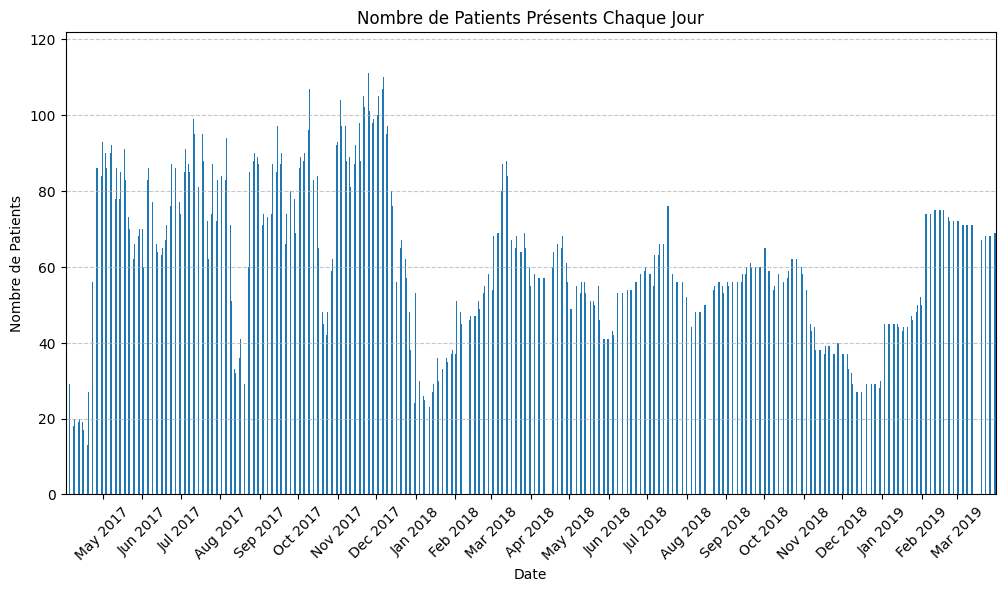

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filtrer les données pour ne garder que les valeurs non nulles
filtered_df = result_df[result_df['Nombre de Patients'] > 0]

# Affichage du graphique en barres sans espace inutile avant et après les données
plt.figure(figsize=(12, 6))
plt.bar(filtered_df['Date'], filtered_df['Nombre de Patients'], width=0.4, align='center')

# Ajouter des labels et un titre
plt.xlabel('Date')
plt.ylabel('Nombre de Patients')
plt.title('Nombre de Patients Présents Chaque Jour')

# Définir les limites de l'axe X pour commencer et terminer aux premières et dernières valeurs non nulles
plt.xlim(filtered_df['Date'].min(), filtered_df['Date'].max())

# Formatter l'axe X pour afficher TOUS les mois
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Afficher chaque mois
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format 'Jan 2024', 'Feb 2024', etc.

# Rotation des dates pour une meilleure lisibilité
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grille sur l'axe Y pour mieux voir les valeurs

# Afficher le graphique
plt.show()


On observe une fluctuation différente car les fêtes ne sont pas les mêmes entre l'Inde et l'Iran

In [11]:
# Afficher le dataset avec toutes les colonnes visibles
pd.set_option('display.max_columns', None)
df
# Retirer la colonne SNO et MRD No.
df = df.drop(columns=['SNO', 'MRD No.'])
df

,D.O.A,D.O.D,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,DURATION OF STAY,duration of intensive unit stay,OUTCOME,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,BNP,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION
28,2017-04-01,2017-04-20,70,F,U,E,Apr-17,20,18,DISCHARGE,0,0,1,1,0,0,0,8.5,0.6,32,158,39,1,EMPTY,1,37,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,2017-04-01,2017-04-02,48,F,U,O,Apr-17,2,0,DISCHARGE,0,0,1,0,0,0,0,10.1,10.8,15,349,199,2.3,EMPTY,0,EMPTY,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-04-01,2017-04-03,53,M,U,E,Apr-17,3,3,DISCHARGE,0,0,1,0,1,0,0,10.6,14.7,329,187,93,2.3,210,0,NaN,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-04-01,2017-04-08,67,F,U,E,Apr-17,8,6,DISCHARGE,0,0,0,1,1,0,0,12.8,9.9,286,130,27,0.6,NaN,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,2017-04-01,2017-04-08,58,F,U,O,Apr-17,8,3,DISCHARGE,0,0,0,1,0,1,0,12.9,12.1,229,112,33,0.8,NaN,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,2019-03-28,2019-04-02,71,M,U,O,Mar-19,6,3,DISCHARGE,0,0,0,0,1,0,0,12.4,14.7,172,267,20,0.92,NaN,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
15727,2019-03-29,2019-04-08,88,M,U,E,Mar-19,11,11,EXPIRY,0,0,0,0,0,1,0,13.5,10.1,378,102,140,1.9,3040,1,28,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
15739,2019-03-30,2019-04-09,49,M,U,O,Mar-19,11,3,DISCHARGE,0,0,0,0,1,0,0,16.9,9.5,264,120,18,0.62,NaN,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15746,2019-03-30,2019-04-01,72,F,U,E,Mar-19,3,3,EXPIRY,0,0,0,1,0,0,1,10.9,20.5,246,138,5.8,1.1,2500,1,35,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


Comme dans l'article, on affiche la distribution des âges des patients

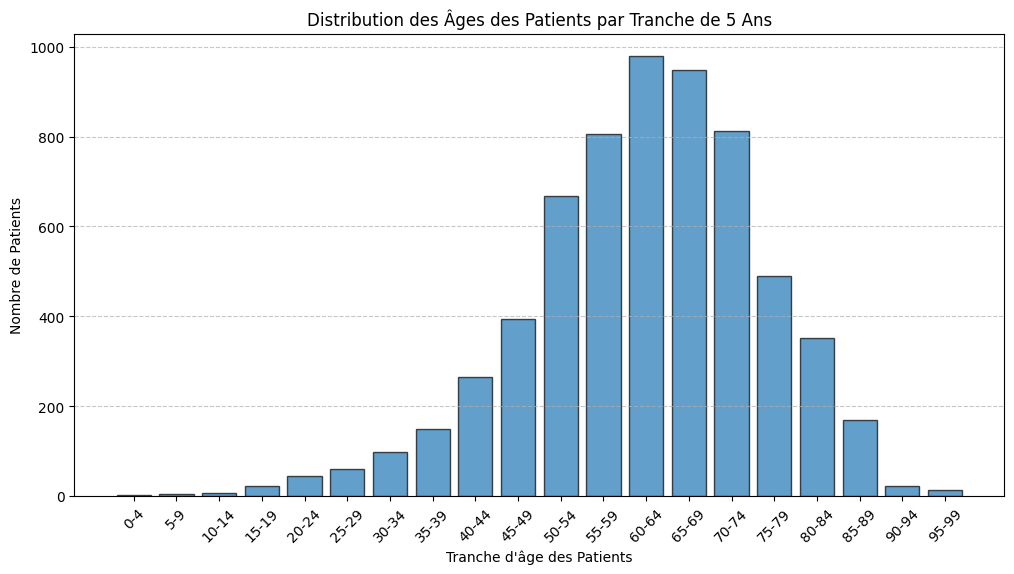

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Vérifier si la colonne 'AGE' existe dans le dataset
if 'AGE' in df.columns:
    # Définir les tranches d'âge (0-4, 5-9, 10-14, ...)
    bins = np.arange(0, df['AGE'].max() + 5, 5)
    labels = [f"{i}-{i+4}" for i in bins[:-1]]  # Créer les labels des tranches

    # Regrouper les âges par tranches de 5 ans
    df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)

    # Compter le nombre de patients par tranche d'âge
    age_group_counts = df['AGE_GROUP'].value_counts().sort_index()

    # Créer un graphique en barres
    plt.figure(figsize=(12, 6))
    plt.bar(age_group_counts.index, age_group_counts.values, width=0.8, edgecolor='black', alpha=0.7)

    # Ajouter des labels et un titre
    plt.xlabel('Tranche d\'âge des Patients')
    plt.ylabel('Nombre de Patients')
    plt.title('Distribution des Âges des Patients par Tranche de 5 Ans')

    # Rotation des labels pour une meilleure lisibilité
    plt.xticks(rotation=45)

    # Afficher la grille pour une meilleure lecture
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Afficher le graphique
    plt.show()
else:
    print("La colonne 'AGE' n'existe pas dans le dataset.")


On a regroupé par tranche de 5 ans car certaines valeurs d'âges étaients imprécises et donc les années finissant par 0 et 5 avaient beaucoup plus de patients

In [13]:
import pandas as pd

# Vérifier si la colonne 'AGE' existe dans le dataset
if 'AGE' in df.columns:
    # Définir les tranches d'âge (0-15, 16-30, ..., 85-99)
    bins = [0, 15, 30, 45, 60, 75, 99]
    labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]  # Créer les labels des tranches

    # Regrouper les âges par tranches définies
    df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)

    # Compter le nombre de patients par tranche d'âge
    age_group_counts = df['AGE_GROUP'].value_counts().sort_index()

    # Calculer la proportion de chaque tranche
    total_patients = age_group_counts.sum()
    age_group_proportion = age_group_counts / total_patients

    # Calculer la proportion cumulative
    cumulative_proportion = age_group_proportion.cumsum()

    # Créer le DataFrame final
    result_table = pd.DataFrame({
        "Age Range": labels,
        "NHP (Number Hospital Patients)": age_group_counts.values,
        "Proportion": age_group_proportion.values,
        "Cumulative Proportion": cumulative_proportion.values
    })

    # Afficher le tableau
    print(result_table)
else:
    print("La colonne 'AGE' n'existe pas dans le dataset.")


  Age Range  NHP (Number Hospital Patients)  Proportion  Cumulative Proportion
0      0-14                              14    0.002221               0.002221
1     15-29                             127    0.020146               0.022367
2     30-44                             510    0.080901               0.103268
3     45-59                            1867    0.296161               0.399429
4     60-74                            2742    0.434962               0.834391
5     75-98                            1044    0.165609               1.000000


On affiche les tendances par tranche d'âge.

C:\Users\ilyes\AppData\Local\Temp\ipykernel_18088\3174006197.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trend_data = df.groupby(['D.O.A', 'AGE_GROUP']).size().unstack().fillna(0)


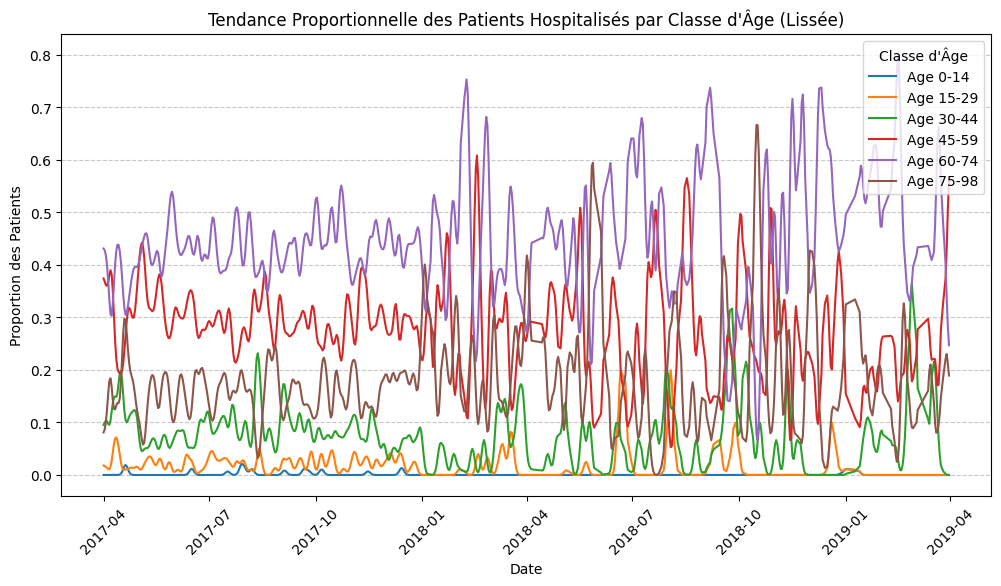

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Vérifier si la colonne 'AGE' et 'D.O.A' existent dans le dataset
if 'AGE' in df.columns and 'D.O.A' in df.columns:
    # Définir les tranches d'âge (0-15, 16-30, ..., 85-99)
    bins = [0, 15, 30, 45, 60, 75, 99]
    labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]

    # Ajouter la colonne de groupes d'âge
    df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)

    # Grouper par date et âge pour obtenir le nombre de patients par tranche d'âge
    trend_data = df.groupby(['D.O.A', 'AGE_GROUP']).size().unstack().fillna(0)

    # Convertir en proportion du total des patients à chaque date
    trend_data = trend_data.div(trend_data.sum(axis=1), axis=0)

    # Appliquer un filtre gaussien pour lisser les courbes
    smoothed_trend_data = trend_data.apply(lambda x: gaussian_filter1d(x, sigma=2), axis=0)

    # Tracer les courbes lissées (proportions au lieu du nombre total)
    plt.figure(figsize=(12, 6))
    for age_class in smoothed_trend_data.columns:
        plt.plot(smoothed_trend_data.index, smoothed_trend_data[age_class], linestyle='-', label=f"Age {age_class}")

    # Ajouter des labels et un titre
    plt.xlabel('Date')
    plt.ylabel('Proportion des Patients')
    plt.title('Tendance Proportionnelle des Patients Hospitalisés par Classe d\'Âge (Lissée)')

    # Légende
    plt.legend(title="Classe d'Âge", loc='upper right')

    # Rotation des dates pour une meilleure lisibilité
    plt.xticks(rotation=45)

    # Afficher la grille pour améliorer la lisibilité
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Afficher le graphique
    plt.show()

else:
    print("Les colonnes 'AGE' et 'D.O.A' sont requises dans le dataset.")


Tendance des "LOS"

In [15]:
import pandas as pd

# Vérifier si la colonne 'DURATION OF STAY' existe dans le dataset
if 'DURATION OF STAY' in df.columns:
    # Sélectionner uniquement les valeurs de LOS entre 1 et 20
    los_counts = df['DURATION OF STAY'].value_counts().sort_index()
    los_counts = los_counts.loc[1:20]  # Garder uniquement les valeurs entre 1 et 20

    # Calculer la proportion de chaque LOS
    total_patients = los_counts.sum()
    los_proportion = los_counts / total_patients

    # Calculer la proportion cumulative
    cumulative_proportion = los_proportion.cumsum()

    # Créer le DataFrame final
    los_table = pd.DataFrame({
        "LOS (Days)": los_counts.index,
        "NHP (Number Hospital Patients)": los_counts.values,
        "Proportion": los_proportion.values,
        "Cumulative Proportion": cumulative_proportion.values
    })

    # Afficher le tableau sur une meme ligne
    pd.set_option('display.expand_frame_repr', False)  # Évite le retour à la ligne automatique
    print(los_table)

else:
    print("La colonne 'DURATION OF STAY' n'existe pas dans le dataset.")


    LOS (Days)  NHP (Number Hospital Patients)  Proportion  Cumulative Proportion
0            1                             328    0.053100               0.053100
1            2                             951    0.153958               0.207058
2            3                             751    0.121580               0.328638
3            4                             713    0.115428               0.444067
4            5                             738    0.119475               0.563542
5            6                             587    0.095030               0.658572
6            7                             492    0.079650               0.738222
7            8                             411    0.066537               0.804760
8            9                             295    0.047758               0.852517
9           10                             231    0.037397               0.889914
10          11                             176    0.028493               0.918407
11          12  

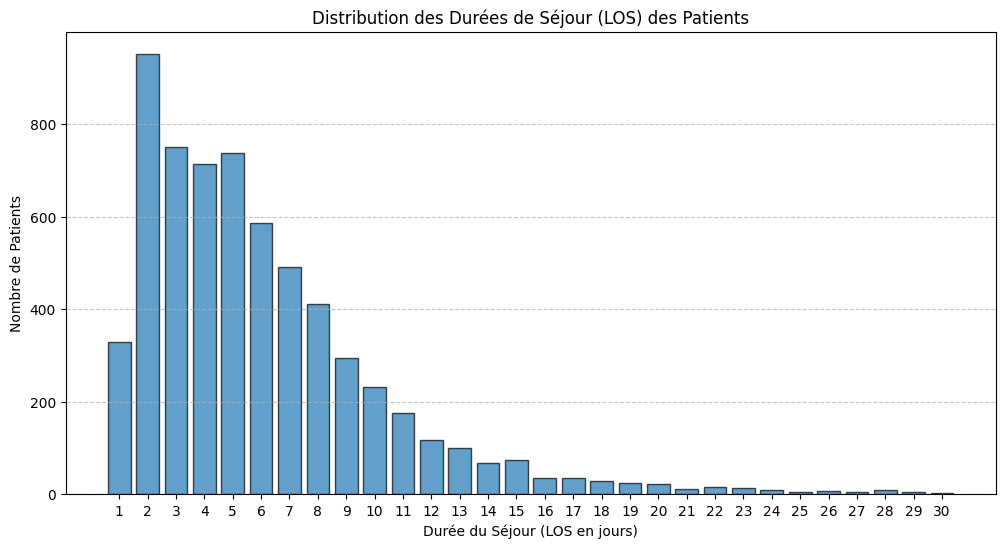

In [16]:
import matplotlib.pyplot as plt

# Vérifier si la colonne 'DURATION OF STAY' existe dans le dataset
if 'DURATION OF STAY' in df.columns:
    # Sélectionner uniquement les valeurs de LOS entre 1 et 30
    los_counts = df['DURATION OF STAY'].value_counts().sort_index()
    los_counts = los_counts.loc[1:30]  # Garder uniquement les valeurs entre 1 et 30

    # Création du graphique en barres
    plt.figure(figsize=(12, 6))
    plt.bar(los_counts.index, los_counts.values, width=0.8, edgecolor='black', alpha=0.7)

    # Ajouter des labels et un titre
    plt.xlabel('Durée du Séjour (LOS en jours)')
    plt.ylabel('Nombre de Patients')
    plt.title('Distribution des Durées de Séjour (LOS) des Patients')

    # Définir les ticks pour afficher chaque valeur de 1 à 30
    plt.xticks(range(1, 31))

    # Afficher la grille pour une meilleure lecture
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Afficher le graphique
    plt.show()
else:
    print("La colonne 'DURATION OF STAY' n'existe pas dans le dataset.")


In [17]:
import pandas as pd

# Vérifier si la colonne 'DURATION OF STAY' existe dans le dataset
if 'DURATION OF STAY' in df.columns:
    # Définir les classes de LOS
    bins = [1, 3, 5, 6, 7, 8, 10, float('inf')]  # Inf pour la dernière catégorie "10+"
    labels = ["1-2", "3-4", "5-6", "6-7", "7-8", "9-10", "10+"]

    # Ajouter la colonne de groupes de LOS
    df['LOS_GROUP7'] = pd.cut(df['DURATION OF STAY'], bins=bins, labels=labels, right=False)

    # Compter le nombre de patients par classe LOS
    los_group_counts = df['LOS_GROUP7'].value_counts().sort_index()

    # Calculer la proportion de chaque classe LOS
    total_patients = los_group_counts.sum()
    los_group_proportion = los_group_counts / total_patients

    # Calculer la proportion cumulative
    cumulative_proportion = los_group_proportion.cumsum()

    # Créer le DataFrame final
    los_table = pd.DataFrame({
        "LOS Range": labels,
        "NHP (Number Hospital Patients)": los_group_counts.values,
        "Proportion": los_group_proportion.values,
        "Cumulative Proportion": cumulative_proportion.values
    })

    # Afficher le tableau
    print(los_table)
else:
    print("La colonne 'DURATION OF STAY' n'existe pas dans le dataset.")


  LOS Range  NHP (Number Hospital Patients)  Proportion  Cumulative Proportion
0       1-2                            1279    0.202887               0.202887
1       3-4                            1464    0.232234               0.435121
2       5-6                             738    0.117069               0.552189
3       6-7                             587    0.093115               0.645305
4       7-8                             492    0.078046               0.723350
5      9-10                             706    0.111992               0.835343
6       10+                            1038    0.164657               1.000000


Tendance entre âge et LOS

C:\Users\ilyes\AppData\Local\Temp\ipykernel_18088\683716484.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  nhp_partition_table = df.pivot_table(index='AGE_GROUP', columns='LOS_GROUP7', aggfunc='size', fill_value=0)


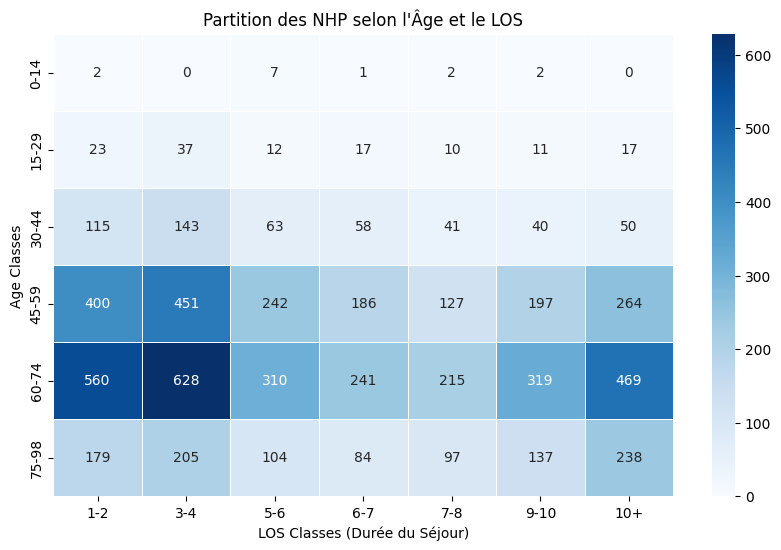

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Vérifier si les colonnes 'AGE' et 'DURATION OF STAY' existent dans le dataset
if 'AGE' in df.columns and 'DURATION OF STAY' in df.columns:
    # Définir les classes d'âge
    age_bins = [0, 15, 30, 45, 60, 75, 99]
    age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins)-1)]

    # Définir les classes de LOS
    los_bins = [1, 3, 5, 6, 7, 8, 10, float('inf')]  # Inf pour la dernière catégorie "10+"
    los_labels = ["1-2", "3-4", "5-6", "6-7", "7-8", "9-10", "10+"]

    # Ajouter les colonnes de groupes
    df['AGE_GROUP'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels, right=False)
    df['LOS_GROUP7'] = pd.cut(df['DURATION OF STAY'], bins=los_bins, labels=los_labels, right=False)

    # Créer le tableau double entrée avec un tableau croisé
    nhp_partition_table = df.pivot_table(index='AGE_GROUP', columns='LOS_GROUP7', aggfunc='size', fill_value=0)

    # Affichage stylisé avec seaborn
    plt.figure(figsize=(10, 6))
    sns.heatmap(nhp_partition_table, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=True)

    # Ajouter des titres et labels
    plt.xlabel("LOS Classes (Durée du Séjour)")
    plt.ylabel("Age Classes")
    plt.title("Partition des NHP selon l'Âge et le LOS")

    # Afficher le graphique
    plt.show()

else:
    print("Les colonnes 'AGE' et 'DURATION OF STAY' sont requises dans le dataset.")


Délimitation pour les classifications en 3 ou 7 "durations of stay"

In [19]:
import pandas as pd

# Vérifier si la colonne 'DURATION OF STAY' existe dans le dataset
if 'DURATION OF STAY' in df.columns:
    # Calculer les quantiles pour diviser en 3 groupes équivalents en effectif
    quantiles = df['DURATION OF STAY'].quantile([1/3, 2/3]).values

    # Définir les nouvelles classes basées sur ces quantiles
    bins = [df['DURATION OF STAY'].min(), quantiles[0], quantiles[1], df['DURATION OF STAY'].max()]
    labels = ["Court", "Moyen", "Long"]

    # Ajouter une colonne LOS_GROUP avec ces nouvelles classes
    df['LOS_GROUP3'] = pd.cut(df['DURATION OF STAY'], bins=bins, labels=labels, include_lowest=True)

    # Calculer la répartition des patients dans chaque classe
    los_group_counts = df['LOS_GROUP3'].value_counts(normalize=True)  # Proportion de chaque classe

    # Créer un tableau avec les classes et leurs plages de valeurs
    los_ranges = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]

    # Créer le DataFrame final
    los_table = pd.DataFrame({
        "LOS Range (Days)": los_ranges,
        "Category": labels,
        "Proportion": los_group_counts.values
    })

    # Afficher le tableau
    print(los_table)
else:
    print("La colonne 'DURATION OF STAY' n'existe pas dans le dataset.")


  LOS Range (Days) Category  Proportion
0              1-4    Court    0.435121
1              4-7    Moyen    0.288230
2             7-98     Long    0.276650


On vérifie que les valeurs sont numériques pour le ML

In [20]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6304 entries, 28 to 15753
Data columns (total 57 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   D.O.A                            6304 non-null   datetime64[ns]
 1   D.O.D                            6304 non-null   datetime64[ns]
 2   AGE                              6304 non-null   int64         
 3   GENDER                           6304 non-null   object        
 4   RURAL                            6304 non-null   object        
 5   TYPE OF ADMISSION-EMERGENCY/OPD  6304 non-null   object        
 6   month year                       6304 non-null   object        
 7   DURATION OF STAY                 6304 non-null   int64         
 8   duration of intensive unit stay  6304 non-null   int64         
 9   OUTCOME                          6304 non-null   object        
 10  SMOKING                          6304 non-null   int64         

In [21]:
df

,D.O.A,D.O.D,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,DURATION OF STAY,duration of intensive unit stay,OUTCOME,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,BNP,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,AGE_GROUP,LOS_GROUP7,LOS_GROUP3
28,2017-04-01,2017-04-20,70,F,U,E,Apr-17,20,18,DISCHARGE,0,0,1,1,0,0,0,8.5,0.6,32,158,39,1,EMPTY,1,37,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60-74,10+,Long
24,2017-04-01,2017-04-02,48,F,U,O,Apr-17,2,0,DISCHARGE,0,0,1,0,0,0,0,10.1,10.8,15,349,199,2.3,EMPTY,0,EMPTY,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45-59,1-2,Court
2,2017-04-01,2017-04-03,53,M,U,E,Apr-17,3,3,DISCHARGE,0,0,1,0,1,0,0,10.6,14.7,329,187,93,2.3,210,0,NaN,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45-59,3-4,Court
3,2017-04-01,2017-04-08,67,F,U,E,Apr-17,8,6,DISCHARGE,0,0,0,1,1,0,0,12.8,9.9,286,130,27,0.6,NaN,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60-74,9-10,Long
18,2017-04-01,2017-04-08,58,F,U,O,Apr-17,8,3,DISCHARGE,0,0,0,1,0,1,0,12.9,12.1,229,112,33,0.8,NaN,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,45-59,9-10,Long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,2019-03-28,2019-04-02,71,M,U,O,Mar-19,6,3,DISCHARGE,0,0,0,0,1,0,0,12.4,14.7,172,267,20,0.92,NaN,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,60-74,6-7,Moyen
15727,2019-03-29,2019-04-08,88,M,U,E,Mar-19,11,11,EXPIRY,0,0,0,0,0,1,0,13.5,10.1,378,102,140,1.9,3040,1,28,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,75-98,10+,Long
15739,2019-03-30,2019-04-09,49,M,U,O,Mar-19,11,3,DISCHARGE,0,0,0,0,1,0,0,16.9,9.5,264,120,18,0.62,NaN,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45-59,10+,Long
15746,2019-03-30,2019-04-01,72,F,U,E,Mar-19,3,3,EXPIRY,0,0,0,1,0,0,1,10.9,20.5,246,138,5.8,1.1,2500,1,35,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,60-74,3-4,Court


In [22]:
print(df.isnull().sum())

D.O.A                                 0
D.O.D                                 0
AGE                                   0
GENDER                                0
RURAL                                 0
TYPE OF ADMISSION-EMERGENCY/OPD       0
month year                            0
DURATION OF STAY                      0
duration of intensive unit stay       0
OUTCOME                               0
SMOKING                               0
ALCOHOL                               0
DM                                    0
HTN                                   0
CAD                                   0
PRIOR CMP                             0
CKD                                   0
HB                                  186
TLC                                 198
PLATELETS                           198
GLUCOSE                             536
UREA                                173
CREATININE                          173
BNP                                4168
RAISED CARDIAC ENZYMES                0


In [23]:
# Suppression de la colonne BNP
df = df.drop(columns=['BNP'])

In [24]:
print(df.isnull().sum())

D.O.A                                0
D.O.D                                0
AGE                                  0
GENDER                               0
RURAL                                0
TYPE OF ADMISSION-EMERGENCY/OPD      0
month year                           0
DURATION OF STAY                     0
duration of intensive unit stay      0
OUTCOME                              0
SMOKING                              0
ALCOHOL                              0
DM                                   0
HTN                                  0
CAD                                  0
PRIOR CMP                            0
CKD                                  0
HB                                 186
TLC                                198
PLATELETS                          198
GLUCOSE                            536
UREA                               173
CREATININE                         173
RAISED CARDIAC ENZYMES               0
EF                                 558
SEVERE ANAEMIA           

In [25]:
df

,D.O.A,D.O.D,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,DURATION OF STAY,duration of intensive unit stay,OUTCOME,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,AGE_GROUP,LOS_GROUP7,LOS_GROUP3
28,2017-04-01,2017-04-20,70,F,U,E,Apr-17,20,18,DISCHARGE,0,0,1,1,0,0,0,8.5,0.6,32,158,39,1,1,37,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60-74,10+,Long
24,2017-04-01,2017-04-02,48,F,U,O,Apr-17,2,0,DISCHARGE,0,0,1,0,0,0,0,10.1,10.8,15,349,199,2.3,0,EMPTY,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45-59,1-2,Court
2,2017-04-01,2017-04-03,53,M,U,E,Apr-17,3,3,DISCHARGE,0,0,1,0,1,0,0,10.6,14.7,329,187,93,2.3,0,NaN,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45-59,3-4,Court
3,2017-04-01,2017-04-08,67,F,U,E,Apr-17,8,6,DISCHARGE,0,0,0,1,1,0,0,12.8,9.9,286,130,27,0.6,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60-74,9-10,Long
18,2017-04-01,2017-04-08,58,F,U,O,Apr-17,8,3,DISCHARGE,0,0,0,1,0,1,0,12.9,12.1,229,112,33,0.8,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,45-59,9-10,Long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,2019-03-28,2019-04-02,71,M,U,O,Mar-19,6,3,DISCHARGE,0,0,0,0,1,0,0,12.4,14.7,172,267,20,0.92,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,60-74,6-7,Moyen
15727,2019-03-29,2019-04-08,88,M,U,E,Mar-19,11,11,EXPIRY,0,0,0,0,0,1,0,13.5,10.1,378,102,140,1.9,1,28,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,75-98,10+,Long
15739,2019-03-30,2019-04-09,49,M,U,O,Mar-19,11,3,DISCHARGE,0,0,0,0,1,0,0,16.9,9.5,264,120,18,0.62,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45-59,10+,Long
15746,2019-03-30,2019-04-01,72,F,U,E,Mar-19,3,3,EXPIRY,0,0,0,1,0,0,1,10.9,20.5,246,138,5.8,1.1,1,35,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,60-74,3-4,Court


In [26]:
# Suppression de toutes les lignes contenant une valeur nulle
df = df.dropna()
df

,D.O.A,D.O.D,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,DURATION OF STAY,duration of intensive unit stay,OUTCOME,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,AGE_GROUP,LOS_GROUP7,LOS_GROUP3
28,2017-04-01,2017-04-20,70,F,U,E,Apr-17,20,18,DISCHARGE,0,0,1,1,0,0,0,8.5,0.6,32,158,39,1,1,37,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60-74,10+,Long
24,2017-04-01,2017-04-02,48,F,U,O,Apr-17,2,0,DISCHARGE,0,0,1,0,0,0,0,10.1,10.8,15,349,199,2.3,0,EMPTY,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45-59,1-2,Court
3,2017-04-01,2017-04-08,67,F,U,E,Apr-17,8,6,DISCHARGE,0,0,0,1,1,0,0,12.8,9.9,286,130,27,0.6,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60-74,9-10,Long
18,2017-04-01,2017-04-08,58,F,U,O,Apr-17,8,3,DISCHARGE,0,0,0,1,0,1,0,12.9,12.1,229,112,33,0.8,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,45-59,9-10,Long
26,2017-04-01,2017-04-04,62,F,R,E,Apr-17,4,1,DISCHARGE,0,0,0,0,0,0,0,13,8.5,213,130,20,0.7,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60-74,3-4,Court
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,2019-03-28,2019-04-02,71,M,U,O,Mar-19,6,3,DISCHARGE,0,0,0,0,1,0,0,12.4,14.7,172,267,20,0.92,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,60-74,6-7,Moyen
15727,2019-03-29,2019-04-08,88,M,U,E,Mar-19,11,11,EXPIRY,0,0,0,0,0,1,0,13.5,10.1,378,102,140,1.9,1,28,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,75-98,10+,Long
15739,2019-03-30,2019-04-09,49,M,U,O,Mar-19,11,3,DISCHARGE,0,0,0,0,1,0,0,16.9,9.5,264,120,18,0.62,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45-59,10+,Long
15746,2019-03-30,2019-04-01,72,F,U,E,Mar-19,3,3,EXPIRY,0,0,0,1,0,0,1,10.9,20.5,246,138,5.8,1.1,1,35,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,60-74,3-4,Court


In [27]:
# Afficher le type de données de chaque colonne
print(df.dtypes)

D.O.A                              datetime64[ns]
D.O.D                              datetime64[ns]
AGE                                         int64
GENDER                                     object
RURAL                                      object
TYPE OF ADMISSION-EMERGENCY/OPD            object
month year                                 object
DURATION OF STAY                            int64
duration of intensive unit stay             int64
OUTCOME                                    object
SMOKING                                     int64
ALCOHOL                                     int64
DM                                          int64
HTN                                         int64
CAD                                         int64
PRIOR CMP                                   int64
CKD                                         int64
HB                                         object
TLC                                        object
PLATELETS                                  object


On veut faire une prédiction sur la durée de séjour (DURATION OF STAY).

On va donc supprimer les colonnes qui donnent des informations sur la durée de séjour

In [28]:
#df = df.drop(columns=['D.O.A', 'D.O.D', 'DURATION OF STAY',])
df = df.drop(columns=['D.O.D', 'DURATION OF STAY',])
# Valeurs possibles pour 'RURAL'
print(df['RURAL'].unique())


['U' 'R']


In [29]:
# Valeurs possibles pour toutes les colonnes dont le type est 'object'
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}: {df[col].unique()}")

GENDER: ['F' 'M']
RURAL: ['U' 'R']
TYPE OF ADMISSION-EMERGENCY/OPD: ['E' 'O']
month year: ['Apr-17' 'May-17' 'Jun-17' 'Jul-17' 'Aug-17' 'Sep-17' 'Oct-17' 'Nov-17'
 'Dec-17' 'Jan-18' 'Feb-18' 'Mar-18' 'Apr-18' 'May-18' 'Jun-18' 'Jul-18'
 'Aug-18' 'Sep-18' 'Oct-18' 'Nov-18' 'Dec-18' 'Jan-19' 'Feb-19' 'Mar-19']
OUTCOME: ['DISCHARGE' 'EXPIRY' 'DAMA']
HB: ['8.5' '10.1' '12.8' '12.9' '13' '13.8' '10.3' '13.2' '10.8' '14.6' '10.5'
 '13.7' '12' '12.7' '15.2' '13.6' '13.5' '13.3' '12.6' '14.9' '11.3'
 '15.1' '12.1' '15.4' '16.3' '14.3' '8.7' '9.5' '13.1' '10' '16.6' '14.5'
 '17.1' '14.2' '14.7' '14.4' '14.8' '12.5' '10.9' '15.5' '14' '9' '15.3'
 '7.4' '16.8' '11.6' '16.9' '10.4' '7.2' '12.4' '11.2' '9.2' '9.7' '15.6'
 '11.1' '11.9' '16' '11.8' '12.2' '8.9' '8.6' '13.4' '16.5' '18.7' '10.6'
 '9.6' '9.9' '9.4' '7.5' '7.9' '9.1' '10.7' '12.3' '13.9' '11.7' '14.1'
 '17.9' '10.2' '6.8' '16.1' '8.3' '11.4' '8.4' '15' '15.7' '15.8' '8.8'
 '16.7' '4.5' '7.6' '15.9' '11.5' '6.4' '7.1' '8.2' '17.4' '5.9'

In [30]:
# On retire OUTCOME et AGE GROUP
df = df.drop(columns=['OUTCOME', 'AGE_GROUP'])

In [31]:
df

,D.O.A,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,duration of intensive unit stay,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,LOS_GROUP7,LOS_GROUP3
28,2017-04-01,70,F,U,E,Apr-17,18,0,0,1,1,0,0,0,8.5,0.6,32,158,39,1,1,37,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,Long
24,2017-04-01,48,F,U,O,Apr-17,0,0,0,1,0,0,0,0,10.1,10.8,15,349,199,2.3,0,EMPTY,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1-2,Court
3,2017-04-01,67,F,U,E,Apr-17,6,0,0,0,1,1,0,0,12.8,9.9,286,130,27,0.6,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9-10,Long
18,2017-04-01,58,F,U,O,Apr-17,3,0,0,0,1,0,1,0,12.9,12.1,229,112,33,0.8,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,9-10,Long
26,2017-04-01,62,F,R,E,Apr-17,1,0,0,0,0,0,0,0,13,8.5,213,130,20,0.7,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3-4,Court
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,2019-03-28,71,M,U,O,Mar-19,3,0,0,0,0,1,0,0,12.4,14.7,172,267,20,0.92,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6-7,Moyen
15727,2019-03-29,88,M,U,E,Mar-19,11,0,0,0,0,0,1,0,13.5,10.1,378,102,140,1.9,1,28,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10+,Long
15739,2019-03-30,49,M,U,O,Mar-19,3,0,0,0,0,1,0,0,16.9,9.5,264,120,18,0.62,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,Long
15746,2019-03-30,72,F,U,E,Mar-19,3,0,0,0,1,0,0,1,10.9,20.5,246,138,5.8,1.1,1,35,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,3-4,Court


In [32]:
# Convertir M/F en 0/1
df['GENDER'] = (df['GENDER'] == 'F').astype(int)

In [33]:
# Convertir URBAN/RURAL en 0/1
df['RURAL'] = (df['RURAL'] == 'RURAL').astype(int)
# Convertir TYPE OF ADMISSION en 0/1
df['TYPE OF ADMISSION'] = (df['TYPE OF ADMISSION-EMERGENCY/OPD'] == 'E').astype(int)
# Supprimer la colonne TYPE OF ADMISSION-EMERGENCY/OPD
df = df.drop(columns=['TYPE OF ADMISSION-EMERGENCY/OPD'])
# Supprimer la colonne duration of intensive unit stay


In [34]:
df = df.drop(columns=['duration of intensive unit stay'])
df

,D.O.A,AGE,GENDER,RURAL,month year,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,LOS_GROUP7,LOS_GROUP3,TYPE OF ADMISSION
28,2017-04-01,70,1,0,Apr-17,0,0,1,1,0,0,0,8.5,0.6,32,158,39,1,1,37,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,Long,1
24,2017-04-01,48,1,0,Apr-17,0,0,1,0,0,0,0,10.1,10.8,15,349,199,2.3,0,EMPTY,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1-2,Court,0
3,2017-04-01,67,1,0,Apr-17,0,0,0,1,1,0,0,12.8,9.9,286,130,27,0.6,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9-10,Long,1
18,2017-04-01,58,1,0,Apr-17,0,0,0,1,0,1,0,12.9,12.1,229,112,33,0.8,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,9-10,Long,0
26,2017-04-01,62,1,0,Apr-17,0,0,0,0,0,0,0,13,8.5,213,130,20,0.7,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3-4,Court,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,2019-03-28,71,0,0,Mar-19,0,0,0,0,1,0,0,12.4,14.7,172,267,20,0.92,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6-7,Moyen,0
15727,2019-03-29,88,0,0,Mar-19,0,0,0,0,0,1,0,13.5,10.1,378,102,140,1.9,1,28,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10+,Long,1
15739,2019-03-30,49,0,0,Mar-19,0,0,0,0,1,0,0,16.9,9.5,264,120,18,0.62,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,Long,0
15746,2019-03-30,72,1,0,Mar-19,0,0,0,1,0,0,1,10.9,20.5,246,138,5.8,1.1,1,35,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,3-4,Court,1


In [35]:
# Types des colonnes
print(df.dtypes)

D.O.A                        datetime64[ns]
AGE                                   int64
GENDER                                int32
RURAL                                 int32
month year                           object
SMOKING                               int64
ALCOHOL                               int64
DM                                    int64
HTN                                   int64
CAD                                   int64
PRIOR CMP                             int64
CKD                                   int64
HB                                   object
TLC                                  object
PLATELETS                            object
GLUCOSE                              object
UREA                                 object
CREATININE                           object
RAISED CARDIAC ENZYMES                int64
EF                                   object
SEVERE ANAEMIA                        int64
ANAEMIA                               int64
STABLE ANGINA                   

In [36]:
import pandas as pd

# Dictionnaire pour convertir les abréviations de mois en nombres
mois_mapping = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

# Vérifier si la colonne 'month year' existe dans le dataset
if 'month year' in df.columns:
    # Extraire le mois et le mapper en nombre
    df['month_numeric'] = df['month year'].str[:3].map(mois_mapping)

    # Afficher un aperçu du résultat
    print(df[['month year', 'month_numeric']].head())
else:
    print("La colonne 'month year' n'existe pas dans le dataset.")


# drop la colonne month year
df = df.drop(columns=['month year'])


   month year  month_numeric
28     Apr-17              4
24     Apr-17              4
3      Apr-17              4
18     Apr-17              4
26     Apr-17              4


In [37]:
df

,D.O.A,AGE,GENDER,RURAL,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,LOS_GROUP7,LOS_GROUP3,TYPE OF ADMISSION,month_numeric
28,2017-04-01,70,1,0,0,0,1,1,0,0,0,8.5,0.6,32,158,39,1,1,37,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,Long,1,4
24,2017-04-01,48,1,0,0,0,1,0,0,0,0,10.1,10.8,15,349,199,2.3,0,EMPTY,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1-2,Court,0,4
3,2017-04-01,67,1,0,0,0,0,1,1,0,0,12.8,9.9,286,130,27,0.6,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9-10,Long,1,4
18,2017-04-01,58,1,0,0,0,0,1,0,1,0,12.9,12.1,229,112,33,0.8,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,9-10,Long,0,4
26,2017-04-01,62,1,0,0,0,0,0,0,0,0,13,8.5,213,130,20,0.7,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3-4,Court,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,2019-03-28,71,0,0,0,0,0,0,1,0,0,12.4,14.7,172,267,20,0.92,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6-7,Moyen,0,3
15727,2019-03-29,88,0,0,0,0,0,0,0,1,0,13.5,10.1,378,102,140,1.9,1,28,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10+,Long,1,3
15739,2019-03-30,49,0,0,0,0,0,0,1,0,0,16.9,9.5,264,120,18,0.62,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,Long,0,3
15746,2019-03-30,72,1,0,0,0,0,1,0,0,1,10.9,20.5,246,138,5.8,1.1,1,35,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,3-4,Court,1,3


In [38]:
# nombre de valeurs 'EMPTY' pour chaque colonne
print(df.isin(['EMPTY']).sum())

D.O.A                         0
AGE                           0
GENDER                        0
RURAL                         0
SMOKING                       0
ALCOHOL                       0
DM                            0
HTN                           0
CAD                           0
PRIOR CMP                     0
CKD                           0
HB                            4
TLC                           4
PLATELETS                     8
GLUCOSE                      75
UREA                          3
CREATININE                    4
RAISED CARDIAC ENZYMES        0
EF                           79
SEVERE ANAEMIA                0
ANAEMIA                       0
STABLE ANGINA                 0
ACS                           0
STEMI                         0
ATYPICAL CHEST PAIN           0
HEART FAILURE                 0
HFREF                         0
HFNEF                         0
VALVULAR                      0
CHB                           0
SSS                           0
AKI     

In [39]:
# suppression de toute les lignes ou il y a une valeur 'EMPTY'
df = df[~df.isin(['EMPTY']).any(axis=1)]
df

,D.O.A,AGE,GENDER,RURAL,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,LOS_GROUP7,LOS_GROUP3,TYPE OF ADMISSION,month_numeric
28,2017-04-01,70,1,0,0,0,1,1,0,0,0,8.5,0.6,32,158,39,1,1,37,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,Long,1,4
3,2017-04-01,67,1,0,0,0,0,1,1,0,0,12.8,9.9,286,130,27,0.6,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9-10,Long,1,4
18,2017-04-01,58,1,0,0,0,0,1,0,1,0,12.9,12.1,229,112,33,0.8,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,9-10,Long,0,4
26,2017-04-01,62,1,0,0,0,0,0,0,0,0,13,8.5,213,130,20,0.7,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3-4,Court,1,4
14,2017-04-01,62,0,0,0,0,1,1,0,0,0,13.8,10.1,187,250,32,0.6,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3-4,Court,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,2019-03-28,71,0,0,0,0,0,0,1,0,0,12.4,14.7,172,267,20,0.92,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6-7,Moyen,0,3
15727,2019-03-29,88,0,0,0,0,0,0,0,1,0,13.5,10.1,378,102,140,1.9,1,28,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10+,Long,1,3
15739,2019-03-30,49,0,0,0,0,0,0,1,0,0,16.9,9.5,264,120,18,0.62,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,Long,0,3
15746,2019-03-30,72,1,0,0,0,0,1,0,0,1,10.9,20.5,246,138,5.8,1.1,1,35,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,3-4,Court,1,3


In [40]:
# types des colonnes
print(df.dtypes)

D.O.A                        datetime64[ns]
AGE                                   int64
GENDER                                int32
RURAL                                 int32
SMOKING                               int64
ALCOHOL                               int64
DM                                    int64
HTN                                   int64
CAD                                   int64
PRIOR CMP                             int64
CKD                                   int64
HB                                   object
TLC                                  object
PLATELETS                            object
GLUCOSE                              object
UREA                                 object
CREATININE                           object
RAISED CARDIAC ENZYMES                int64
EF                                   object
SEVERE ANAEMIA                        int64
ANAEMIA                               int64
STABLE ANGINA                         int64
ACS                             

In [41]:
# transformer toutes les colonnes de type object en type int64 ou float si impossible
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = df[col].astype(int)
        except ValueError:
            df[col] = df[col].astype(float)

C:\Users\ilyes\AppData\Local\Temp\ipykernel_18088\3681516623.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
C:\Users\ilyes\AppData\Local\Temp\ipykernel_18088\3681516623.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
C:\Users\ilyes\AppData\Local\Temp\ipykernel_18088\3681516623.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [42]:
df

,D.O.A,AGE,GENDER,RURAL,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,LOS_GROUP7,LOS_GROUP3,TYPE OF ADMISSION,month_numeric
28,2017-04-01,70,1,0,0,0,1,1,0,0,0,8.5,0.6,32.0,158.0,39.0,1.00,1,37,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,Long,1,4
3,2017-04-01,67,1,0,0,0,0,1,1,0,0,12.8,9.9,286.0,130.0,27.0,0.60,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9-10,Long,1,4
18,2017-04-01,58,1,0,0,0,0,1,0,1,0,12.9,12.1,229.0,112.0,33.0,0.80,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,9-10,Long,0,4
26,2017-04-01,62,1,0,0,0,0,0,0,0,0,13.0,8.5,213.0,130.0,20.0,0.70,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3-4,Court,1,4
14,2017-04-01,62,0,0,0,0,1,1,0,0,0,13.8,10.1,187.0,250.0,32.0,0.60,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3-4,Court,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,2019-03-28,71,0,0,0,0,0,0,1,0,0,12.4,14.7,172.0,267.0,20.0,0.92,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6-7,Moyen,0,3
15727,2019-03-29,88,0,0,0,0,0,0,0,1,0,13.5,10.1,378.0,102.0,140.0,1.90,1,28,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10+,Long,1,3
15739,2019-03-30,49,0,0,0,0,0,0,1,0,0,16.9,9.5,264.0,120.0,18.0,0.62,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,Long,0,3
15746,2019-03-30,72,1,0,0,0,0,1,0,0,1,10.9,20.5,246.0,138.0,5.8,1.10,1,35,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,3-4,Court,1,3


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4996 entries, 28 to 15753
Data columns (total 51 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   D.O.A                      4996 non-null   datetime64[ns]
 1   AGE                        4996 non-null   int64         
 2   GENDER                     4996 non-null   int32         
 3   RURAL                      4996 non-null   int32         
 4   SMOKING                    4996 non-null   int64         
 5   ALCOHOL                    4996 non-null   int64         
 6   DM                         4996 non-null   int64         
 7   HTN                        4996 non-null   int64         
 8   CAD                        4996 non-null   int64         
 9   PRIOR CMP                  4996 non-null   int64         
 10  CKD                        4996 non-null   int64         
 11  HB                         4996 non-null   float64       
 12  TLC      

In [44]:
df

,D.O.A,AGE,GENDER,RURAL,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,LOS_GROUP7,LOS_GROUP3,TYPE OF ADMISSION,month_numeric
28,2017-04-01,70,1,0,0,0,1,1,0,0,0,8.5,0.6,32.0,158.0,39.0,1.00,1,37,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,Long,1,4
3,2017-04-01,67,1,0,0,0,0,1,1,0,0,12.8,9.9,286.0,130.0,27.0,0.60,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9-10,Long,1,4
18,2017-04-01,58,1,0,0,0,0,1,0,1,0,12.9,12.1,229.0,112.0,33.0,0.80,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,9-10,Long,0,4
26,2017-04-01,62,1,0,0,0,0,0,0,0,0,13.0,8.5,213.0,130.0,20.0,0.70,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3-4,Court,1,4
14,2017-04-01,62,0,0,0,0,1,1,0,0,0,13.8,10.1,187.0,250.0,32.0,0.60,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3-4,Court,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,2019-03-28,71,0,0,0,0,0,0,1,0,0,12.4,14.7,172.0,267.0,20.0,0.92,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6-7,Moyen,0,3
15727,2019-03-29,88,0,0,0,0,0,0,0,1,0,13.5,10.1,378.0,102.0,140.0,1.90,1,28,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10+,Long,1,3
15739,2019-03-30,49,0,0,0,0,0,0,1,0,0,16.9,9.5,264.0,120.0,18.0,0.62,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,Long,0,3
15746,2019-03-30,72,1,0,0,0,0,1,0,0,1,10.9,20.5,246.0,138.0,5.8,1.10,1,35,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,3-4,Court,1,3


In [45]:
#Transforme LOS_GROUP3 en 0, 1, 2
df['LOS_GROUP3'] = df['LOS_GROUP3'].map({'Court': 0, 'Moyen': 1, 'Long': 2})
df

C:\Users\ilyes\AppData\Local\Temp\ipykernel_18088\1752230762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LOS_GROUP3'] = df['LOS_GROUP3'].map({'Court': 0, 'Moyen': 1, 'Long': 2})


,D.O.A,AGE,GENDER,RURAL,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,LOS_GROUP7,LOS_GROUP3,TYPE OF ADMISSION,month_numeric
28,2017-04-01,70,1,0,0,0,1,1,0,0,0,8.5,0.6,32.0,158.0,39.0,1.00,1,37,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,2,1,4
3,2017-04-01,67,1,0,0,0,0,1,1,0,0,12.8,9.9,286.0,130.0,27.0,0.60,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9-10,2,1,4
18,2017-04-01,58,1,0,0,0,0,1,0,1,0,12.9,12.1,229.0,112.0,33.0,0.80,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,9-10,2,0,4
26,2017-04-01,62,1,0,0,0,0,0,0,0,0,13.0,8.5,213.0,130.0,20.0,0.70,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3-4,0,1,4
14,2017-04-01,62,0,0,0,0,1,1,0,0,0,13.8,10.1,187.0,250.0,32.0,0.60,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3-4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,2019-03-28,71,0,0,0,0,0,0,1,0,0,12.4,14.7,172.0,267.0,20.0,0.92,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6-7,1,0,3
15727,2019-03-29,88,0,0,0,0,0,0,0,1,0,13.5,10.1,378.0,102.0,140.0,1.90,1,28,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10+,2,1,3
15739,2019-03-30,49,0,0,0,0,0,0,1,0,0,16.9,9.5,264.0,120.0,18.0,0.62,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10+,2,0,3
15746,2019-03-30,72,1,0,0,0,0,1,0,0,1,10.9,20.5,246.0,138.0,5.8,1.10,1,35,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,3-4,0,1,3


In [46]:
#Transformer LOS_GROUP7 en 0, 1, 2, 3, 4, 5, 6
df['LOS_GROUP7'] = df['LOS_GROUP7'].map({'1-2': 0, '3-4': 1, '5-6': 2, '6-7': 3, '7-8': 4, '9-10': 5, '10+': 6})
df
DOA_col = df['D.O.A']
#drop D.O.A
df = df.drop(columns=['D.O.A'])

C:\Users\ilyes\AppData\Local\Temp\ipykernel_18088\3200001673.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LOS_GROUP7'] = df['LOS_GROUP7'].map({'1-2': 0, '3-4': 1, '5-6': 2, '6-7': 3, '7-8': 4, '9-10': 5, '10+': 6})


In [47]:
# Enlever LOS7 
df3 = df.drop(columns=['LOS_GROUP7'])
df3
# Enlever LOS3
df7 = df.drop(columns=['LOS_GROUP3'])
df7

,AGE,GENDER,RURAL,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,LOS_GROUP7,TYPE OF ADMISSION,month_numeric
28,70,1,0,0,0,1,1,0,0,0,8.5,0.6,32.0,158.0,39.0,1.00,1,37,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1,4
3,67,1,0,0,0,0,1,1,0,0,12.8,9.9,286.0,130.0,27.0,0.60,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,4
18,58,1,0,0,0,0,1,0,1,0,12.9,12.1,229.0,112.0,33.0,0.80,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,5,0,4
26,62,1,0,0,0,0,0,0,0,0,13.0,8.5,213.0,130.0,20.0,0.70,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,4
14,62,0,0,0,0,1,1,0,0,0,13.8,10.1,187.0,250.0,32.0,0.60,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15671,71,0,0,0,0,0,0,1,0,0,12.4,14.7,172.0,267.0,20.0,0.92,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,3
15727,88,0,0,0,0,0,0,0,1,0,13.5,10.1,378.0,102.0,140.0,1.90,1,28,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,1,3
15739,49,0,0,0,0,0,0,1,0,0,16.9,9.5,264.0,120.0,18.0,0.62,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,3
15746,72,1,0,0,0,0,1,0,0,1,10.9,20.5,246.0,138.0,5.8,1.10,1,35,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3


On visualise les features

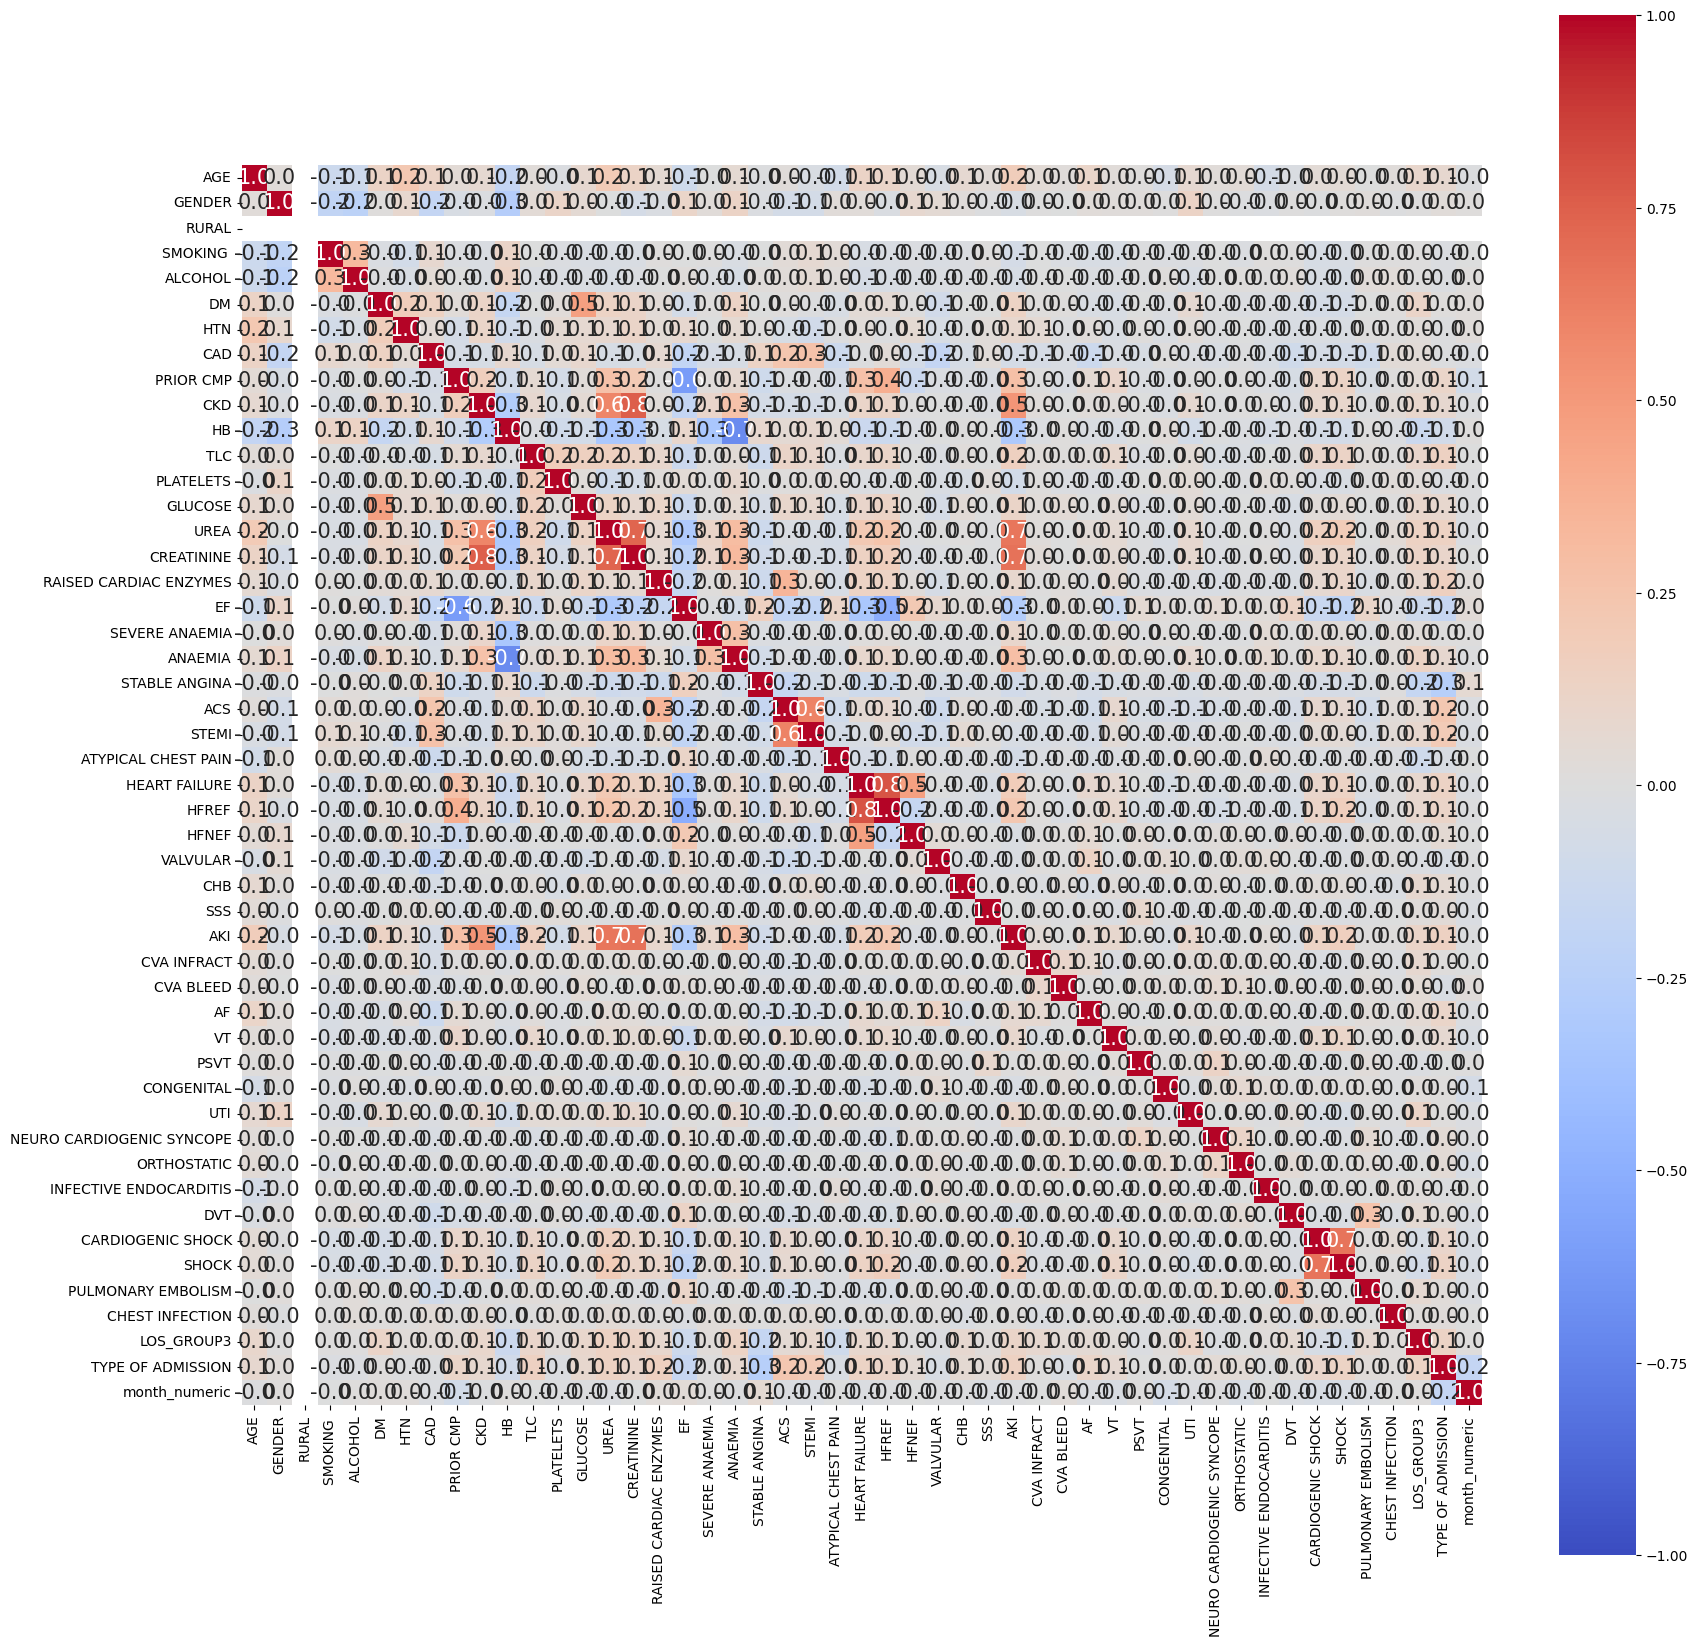

In [48]:
corr1 = df3.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr1, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.show()

### Partie Machine Learning

In [49]:
X = df3.drop('LOS_GROUP3', axis=1)
y = df3['LOS_GROUP3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [50]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
y_pred_train = knn.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)

C:\Users\ilyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ilyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

In [51]:
print("Accuracy (train)=", accuracy_train)
print("Accuracy =", accuracy)
#print(classification_report(y_test, y_pred))

Accuracy (train)= 0.5784958535887904
Accuracy = 0.40093395597064707


In [52]:
X = df7.drop('LOS_GROUP7', axis=1)
y = df7['LOS_GROUP7']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [53]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
y_pred_train = knn.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)

In [54]:
print("Accuracy (train)=", accuracy_train)
print("Accuracy =", accuracy)
#print(classification_report(y_test, y_pred))

Accuracy (train)= 0.44981412639405205
Accuracy = 0.20613742494996665


In [55]:
X = df3.drop('LOS_GROUP3', axis=1)
y = df3['LOS_GROUP3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Accuracy (train)= 1.0
Accuracy = 0.505003335557038
              precision    recall  f1-score   support

           0       0.54      0.60      0.57       552
           1       0.47      0.38      0.42       490
           2       0.49      0.53      0.51       457

    accuracy                           0.51      1499
   macro avg       0.50      0.50      0.50      1499
weighted avg       0.50      0.51      0.50      1499

Matrice de confusion:


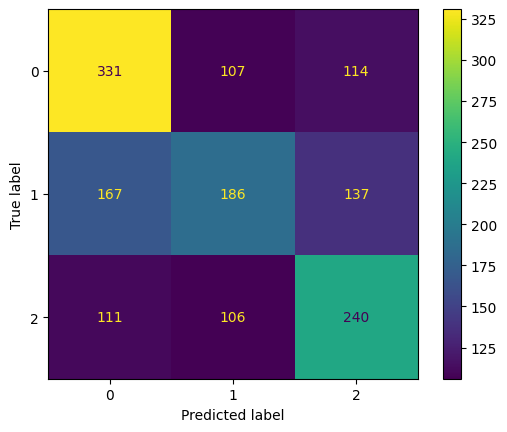

In [56]:
rf = RandomForestClassifier( #We're fixing the base parameters
    n_estimators=100, 
    max_depth=None,  
    random_state=1  
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_train = rf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)

conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy (train)=", accuracy_train)
print("Accuracy =", accuracy)

print(classification_report(y_test, y_pred))

print("Matrice de confusion:")
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

In [57]:
X = df7.drop('LOS_GROUP7', axis=1)
y = df7['LOS_GROUP7']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Accuracy (train)= 1.0
Accuracy = 0.30420280186791193
              precision    recall  f1-score   support

           0       0.41      0.25      0.31       212
           1       0.30      0.58      0.40       340
           2       0.19      0.06      0.09       212
           3       0.22      0.11      0.15       152
           4       0.35      0.06      0.11       126
           5       0.17      0.09      0.11       175
           6       0.34      0.54      0.41       282

    accuracy                           0.30      1499
   macro avg       0.28      0.24      0.23      1499
weighted avg       0.29      0.30      0.26      1499

Matrice de confusion:


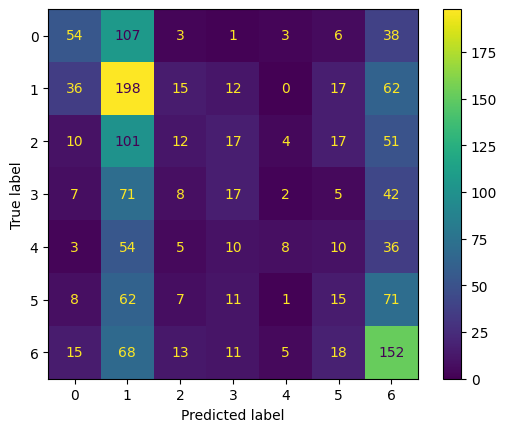

In [58]:
rf = RandomForestClassifier( #We're fixing the base parameters
    n_estimators=100, 
    max_depth=None,  
    random_state=1  
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_train = rf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)

conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy (train)=", accuracy_train)
print("Accuracy =", accuracy)

print(classification_report(y_test, y_pred))

print("Matrice de confusion:")
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

#### Conclusion – Partie Machine Learning

On observe que, pour tous les algorithmes testés, les résultats en termes d’accuracy sont **largement supérieurs au hasard** (i.e. meilleure que `1 / nb de classes`), ce qui montre que les modèles apprennent bien des patterns dans les données.

Cependant, les performances restent **globalement inférieures (de 10 à 20%)** à celles rapportées dans l’article original. Cela peut s'expliquer par deux raisons principales :
- Nous n’avons pas effectué d’**optimisation poussée des hyperparamètres**
- Le **dataset utilisé est différent**, et probablement moins propre ou moins riche que celui de l’étude initiale

---

**Résumé des performances :**

| Modèle          | Nb de classes | Accuracy (test) |
|-----------------|----------------|-----------------|
| Random Forest   | 3              | 50 %            |
| Random Forest   | 7              | 30 %            |
| K-Nearest Neighbors | 3          | 40 %            |
| K-Nearest Neighbors | 7          | 20 %            |

---

Ces résultats restent cohérents avec la littérature, et montrent que même sans optimisation avancée, ces algorithmes peuvent fournir des bases solides pour des décisions hospitalières futures.


### Partie Programmation Mathématique X Machine Learning

Dans cette partie, nous allons choisir d'ajouter une contrainte à nos prédictions de LOS. Nous choisissons arbitrairement (par rapport à nos valeurs) de mettre une limite de 50 patients maximum pour cet hôpital.

In [59]:
los_days_mapping = {
    0: 2,
    1: 4,
    2: 6,
    3: 7,
    4: 8,
    5: 10,
    6: 14
}

durations_pred = [los_days_mapping[c] for c in y_pred]


In [60]:
df7['D.O.A'] = DOA_col # ou df7 si c’est le bon nom


In [61]:
df7['D.O.A'] = DOA_col.values


In [62]:
from sklearn.model_selection import train_test_split

# Séparation des features, label et D.O.A
X = df7.drop(['LOS_GROUP7'], axis=1)
y = df7['LOS_GROUP7']
DOA_col = X['D.O.A']
X = X.drop('D.O.A', axis=1)  # On ne garde pas D.O.A dans les features du modèle

# Split X, y, DOA_col
X_train, X_test, y_train, y_test, doa_train, doa_test = train_test_split(
    X, y, DOA_col, test_size=0.3, random_state=1
)


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy =", accuracy)


Accuracy = 0.30420280186791193


In [64]:
los_days_mapping = {
    0: 2,    # "1-2"
    1: 4,    # "3-4"
    2: 6,    # "5-6"
    3: 7,    # "6-7"
    4: 8,    # "7-8"
    5: 10,   # "9-10"
    6: 14    # "10+"
}
durations_pred = [los_days_mapping[c] for c in y_pred]


In [65]:
import pandas as pd

df_test_pred = pd.DataFrame({
    'D.O.A': pd.to_datetime(doa_test),
    'LOS_days': durations_pred
})


In [66]:
from collections import Counter

all_days = []

for i, row in df_test_pred.iterrows():
    start = row['D.O.A']
    end = start + pd.Timedelta(days=row['LOS_days'])
    all_days.extend(pd.date_range(start, end - pd.Timedelta(days=1)))


In [67]:
hospital_load = pd.Series(Counter(all_days)).sort_index()


On affiche le nombre de patients prédits via l'algorithme de machine learning

📅 Jours en surcharge (>50 patients) :
2017-06-17    51
2017-11-29    55
2017-11-30    60
2017-12-01    60
2017-12-02    58
2017-12-03    58
2017-12-05    52
2017-12-06    53
2017-12-08    52
dtype: int64


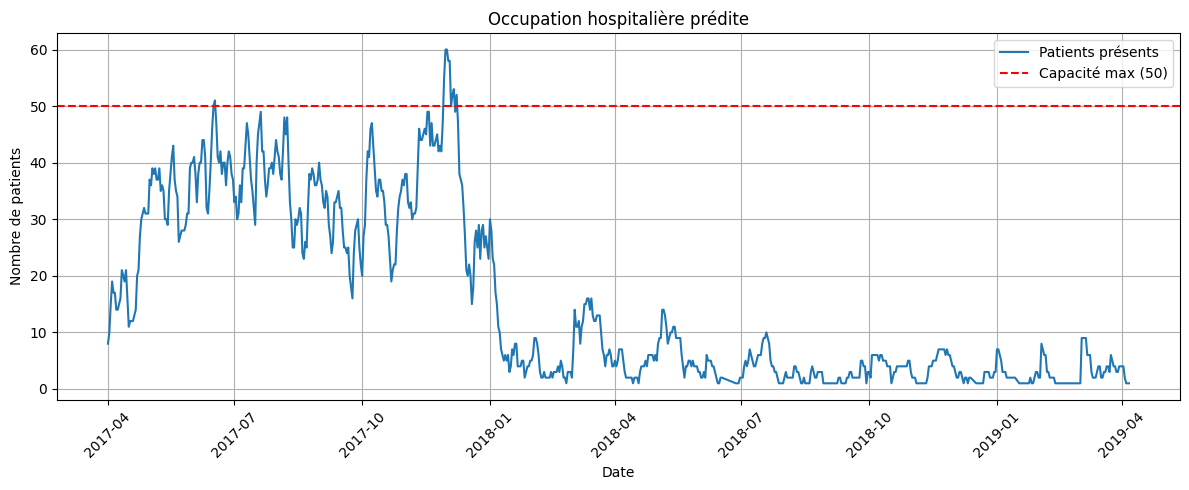

In [68]:
import matplotlib.pyplot as plt

overload_days = hospital_load[hospital_load > 50]
print("📅 Jours en surcharge (>50 patients) :")
print(overload_days)

plt.figure(figsize=(12, 5))
plt.plot(hospital_load.index, hospital_load.values, label="Patients présents")
plt.axhline(50, color='red', linestyle='--', label="Capacité max (50)")
plt.xlabel("Date")
plt.ylabel("Nombre de patients")
plt.title("Occupation hospitalière prédite")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [69]:
df_test_pred = pd.DataFrame({
    'D.O.A': pd.to_datetime(doa_test).reset_index(drop=True),
    'LOS_class': y_pred,
    'LOS_days': durations_pred
})


In [70]:
def compute_load(df):
    all_days = []
    for _, row in df.iterrows():
        for d in range(row['LOS_days']):
            all_days.append(row['D.O.A'] + pd.Timedelta(days=d))
    return pd.Series(Counter(all_days)).sort_index()


On optimise le nombre de patients pour limiter à 50 maximum 

In [71]:
import numpy as np

# Dictionnaire inversé pour passer d'une classe LOS à une durée
los_days_mapping = {
    0: 2, 1: 4, 2: 6, 3: 7, 4: 8, 5: 10, 6: 14
}
# Et inverse (durée → classe)
inverse_mapping = {v: k for k, v in los_days_mapping.items()}

# Tri décroissant des LOS (priorité à ceux qui restent longtemps)
ordered_classes = [6, 5, 4, 3, 2, 1, 0]

while True:
    load = compute_load(df_test_pred)
    if load.max() <50:
        break  # on est bon

    # Trouver le jour le plus surchargé
    worst_day = load.idxmax()

    # Patients présents ce jour-là
    patients_present = df_test_pred[
        (df_test_pred['D.O.A'] <= worst_day) &
        (df_test_pred['D.O.A'] + pd.to_timedelta(df_test_pred['LOS_days'], unit='D') > worst_day)
    ]

    # Essayer de réduire la durée d’un patient "long" présent ce jour-là
    for idx in patients_present.index:
        current_class = df_test_pred.loc[idx, 'LOS_class']
        if current_class > 0:  # on peut réduire
            new_class = current_class - 1
            df_test_pred.at[idx, 'LOS_class'] = new_class
            df_test_pred.at[idx, 'LOS_days'] = los_days_mapping[new_class]
            break  # on réduit un seul patient à la fois


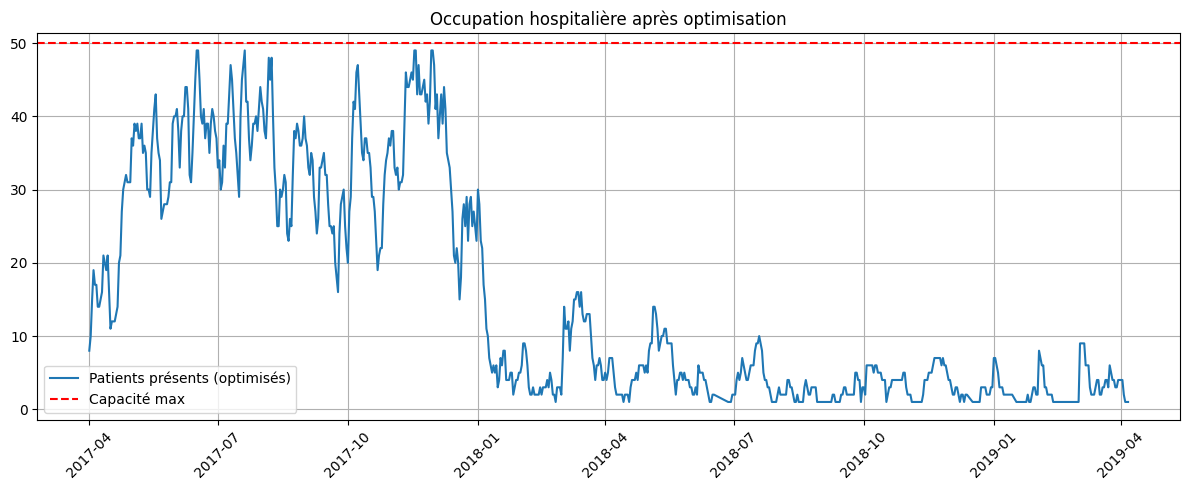

In [72]:
final_load = compute_load(df_test_pred)

plt.figure(figsize=(12, 5))
plt.plot(final_load.index, final_load.values, label="Patients présents (optimisés)")
plt.axhline(50, color='red', linestyle='--', label="Capacité max")
plt.title("Occupation hospitalière après optimisation")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


On observe les différences apportées par l'optimisation

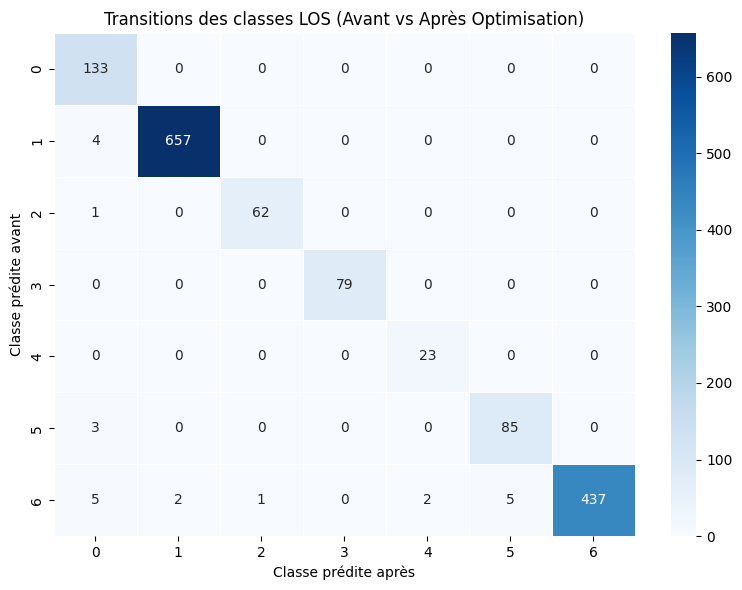

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Créer un DataFrame pour comparer les deux colonnes
comparison_df = pd.DataFrame({
    'LOS_class_before': y_pred,
    'LOS_class_after': df_test_pred['LOS_class'].values  # après optimisation
})

# Matrice de confusion (transition de classe)
los_change_matrix = pd.crosstab(comparison_df['LOS_class_before'], comparison_df['LOS_class_after'])
los_change_matrix.index.name = "LOS Avant"
los_change_matrix.columns.name = "LOS Après"

# Affichage en heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(los_change_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Transitions des classes LOS (Avant vs Après Optimisation)")
plt.xlabel("Classe prédite après")
plt.ylabel("Classe prédite avant")
plt.tight_layout()
plt.show()


On observe que la matrice des transitions LOS a une forme en "L", c’est-à-dire qu’il n’y aucune valeur dans la partie supérieure droite.  
C’est normal : notre algorithme d’optimisation ne fait que **réduire** les classes de durée de séjour lorsque la capacité maximale est dépassée, sans jamais les augmenter.  
Toutes les transitions se situent donc soit sur la diagonale (aucun changement), soit en dessous (réduction).


#### Conclusion – Optimisation appliquée à l'hôpital

Dans cette partie, on a utilisé les prédictions de durée de séjour (LOS) pour simuler l’occupation quotidienne de l’hôpital à partir des dates d’admission.  
Cela nous a permis de voir combien de patients seraient présents chaque jour, et d'identifier les jours où la capacité maximale (ici fixée à 50 lits) était dépassée.

On a ensuite mis en place une logique d’optimisation simple qui réduit certaines durées de séjour quand la charge dépasse la limite.  
L’objectif était de limiter la surcharge tout en modifiant le moins possible les prédictions du modèle.

Ici, on a fixé la limite à 50 de façon arbitraire, mais dans un contexte réel, choisir un bon seuil serait un travail à part entière.  
Il ne s’agirait pas forcément du maximum physique de l’hôpital, mais plutôt d’une **marge de sécurité** permettant d’absorber les pics inattendus ou les nouvelles admissions non encore prévues.  
Un tel système pourrait aussi servir à **anticiper les besoins en lits supplémentaires** à l’avance, en détectant les périodes de tension à venir.

Ce genre d’approche montre comment on peut combiner Machine Learning et programmation mathématique pour créer des outils concrets d’aide à la décision dans un contexte hospitalier.
